In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse
import seaborn as sns
import hdbscan
import rasterio  
from rasterio.plot import show
from affine import Affine
import geopandas as gpd
from shapely.geometry import Point
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, silhouette_score
from scipy.interpolate import griddata
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures

In [1]:
density_X_dir = r"C:\Data\ONGC\AIKosh\ground_gravity_data_of_karnataka_and_andhra_pradesh_v1\Ground_gravity_asci_grid_geotiff\Physical_properties_rock_samples_Copy.csv"
ngpm_grav_dir = r"C:\Data\ONGC\AIKosh\ground_gravity_data_of_karnataka_and_andhra_pradesh_v1\Ground_gravity_asci_grid_geotiff\ASCII\combined_NGPM_gravity - Copy.csv"
bouguer_anomaly_dir = r"C:\Data\ONGC\AIKosh\ground_gravity_data_of_karnataka_and_andhra_pradesh_v1\Ground_gravity_asci_grid_geotiff\GEOTIFF\NGPM_BA.tiff"
gdb_dir = r"C:\Data\ONGC\AIKosh\aerogeophysical_spectrometric_data_of_karnataka_and_andhra_pradesh_v1\SPECTROMETRIC\DATABASE\GDB\spec.gdb"
tail_tmi_ge = r"C:\Data\ONGC\AIKosh\aerogeophysical_magnetic_data_of_karnataka_and_andhra_pradesh_v1\MAGNETIC\GRIDS\GEOTIFF\TAIL_TMI_GE.tiff"
geo_map_dir = r"C:\Data\ONGC\AIKosh\Geological_Map.tif"
xyz_dir = r"C:\Data\ONGC\AIKosh\aerogeophysical_magnetic_data_of_karnataka_and_andhra_pradesh_v1\MAGNETIC\DATABASE\XYZ\mag.XYZ"
tmi_cleaned_dir = r"C:\Data\ONGC\AIKosh\OUTPUT\TMI_Cleaned.txt"
output_dir = r"C:\Data\ONGC\AIKosh\OUTPUT\GM Data"

In [12]:
df_density = pd.read_csv(density_X_dir)
print(df_density.head())

   Latitude  Longitude  Density (g/cc)     Rock_type  Susceptibility  \
0     15.40      76.01            2.62  Pink Granite            35.4   
1     15.34      76.11            2.72    Hornblende           739.0   
2     15.26      76.07            2.56     Pegmatite             5.7   
3     15.28      76.07            3.05        Gabbro             2.3   
4     15.37      76.02            2.52     Pegmatite             4.4   

           x           y  
0  608382.92  1702822.25  
1  619149.09  1696237.42  
2  614898.61  1687365.88  
3  614887.73  1689578.35  
4  609471.79  1699508.60  


In [13]:
# Drop missing rock_type
df_density = df_density.copy()
df_density = df_density.dropna(subset=["Rock_type"])

In [14]:
df_density["log_Susceptibility"] = np.log(df_density["Susceptibility"].replace(0, np.nan)).fillna(0)

C:\Users\Kunal\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [15]:
rocktypes = df_density['Rock_type'].unique()
rocktype_counts = df_density["Rock_type"].value_counts(dropna=False)

In [16]:
len(rocktypes), rocktype_counts, 

(49,
 Rock_type
 Pink Granite                      68
 Granite                           64
 Dolerite                          32
 Grey Granite                      28
 Granite Gneiss                    27
 Amphibolite                       26
 Gabbro                            16
 Granodiorite                      16
 Metabasalt                         8
 Porphyritic Granite                7
 Pink Porphyritic Granite           6
 Weathered granite                  6
 MME                                5
 Applite                            4
 Pegmatite                          4
 Migmatite                          3
 Quartz vein                        3
 Banded Iron Formation              3
 Mafic Granite                      2
 Quartzite                          2
 Quartz Chlorite Schist             2
 Tonalite                           2
 Hornblende Granite                 2
 Meta Gabbro                        2
 Sheared Granite                    2
 Schist                           

In [17]:
df_density

,Latitude,Longitude,Density (g/cc),Rock_type,Susceptibility,x,y,log_Susceptibility
0,15.40,76.01,2.62,Pink Granite,35.40,608382.92,1702822.25,3.566712
1,15.34,76.11,2.72,Hornblende,739.00,619149.09,1696237.42,6.605298
2,15.26,76.07,2.56,Pegmatite,5.70,614898.61,1687365.88,1.740466
3,15.28,76.07,3.05,Gabbro,2.30,614887.73,1689578.35,0.832909
4,15.37,76.02,2.52,Pegmatite,4.40,609471.79,1699508.60,1.481605
...,...,...,...,...,...,...,...,...
359,14.45,77.57,2.61,Sheared Granite,9.10,777069.64,1599046.37,2.208274
360,14.33,77.24,2.59,Syeno Granite,26.05,741604.55,1585392.53,3.260018
361,14.48,77.09,2.60,Tonalite,122.70,725268.40,1601840.64,4.809742
362,14.27,77.05,2.59,Tonalite,181.55,721161.92,1578562.85,5.201531


In [18]:
top_n = 8
top_rocktypes = df_density["Rock_type"].value_counts().index[:top_n]
df_density["Rocktype_Grouped"] = df_density["Rock_type"].apply(lambda x: x if x in top_rocktypes else "Other")

In [19]:
custom_palette = {"Pink Granite": "deeppink", "Granite": "tab:blue", "Dolerite": "tab:green", "Grey Granite": "tab:orange",
    "Amphibolite": "tab:red", "Granite gneiss": "tab:purple", "Gabbro": "tab:brown", "Granodiorite": "tab:cyan", "Granite Gneiss": "tab:olive",
    "Porphyritic Granite": "tab:gray", "Other": "lightgrey"}

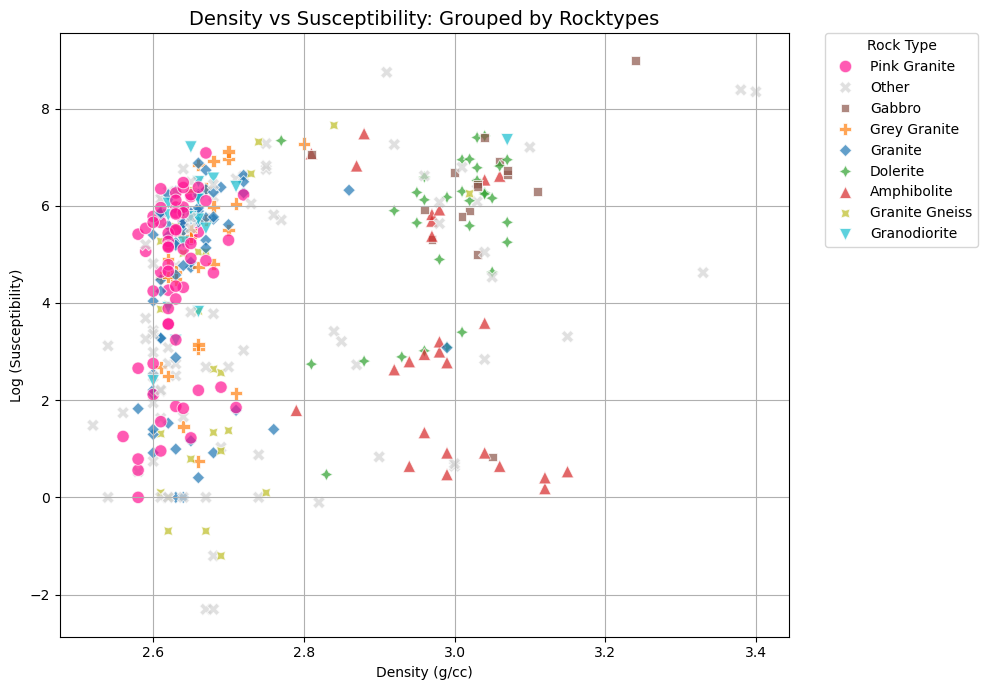

In [20]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=df_density, x="Density (g/cc)", y=df_density["log_Susceptibility"], hue="Rocktype_Grouped", style="Rocktype_Grouped", palette=custom_palette,
    s=80, alpha=0.7)
plt.title("Density vs Susceptibility: Grouped by Rocktypes", fontsize=14)
plt.xlabel("Density (g/cc)")
plt.ylabel("Log (Susceptibility)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Rock Type", borderaxespad=0.)
plt.tight_layout()
plt.savefig(rf"{output_dir}\Crossplots\Density vs log(Susceptibility) by Rocktype Grouped.png")
plt.show()

In [21]:
X = df_density[["Density (g/cc)", "log_Susceptibility"]].values

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [23]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
cluster_labels = clusterer.fit_predict(X_scaled)

In [24]:
df_density["Cluster"] = cluster_labels
palette = sns.color_palette("husl", len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0))

In [25]:
df_density

,Latitude,Longitude,Density (g/cc),Rock_type,Susceptibility,x,y,log_Susceptibility,Rocktype_Grouped,Cluster
0,15.40,76.01,2.62,Pink Granite,35.40,608382.92,1702822.25,3.566712,Pink Granite,2
1,15.34,76.11,2.72,Hornblende,739.00,619149.09,1696237.42,6.605298,Other,2
2,15.26,76.07,2.56,Pegmatite,5.70,614898.61,1687365.88,1.740466,Other,2
3,15.28,76.07,3.05,Gabbro,2.30,614887.73,1689578.35,0.832909,Gabbro,-1
4,15.37,76.02,2.52,Pegmatite,4.40,609471.79,1699508.60,1.481605,Other,2
...,...,...,...,...,...,...,...,...,...,...
359,14.45,77.57,2.61,Sheared Granite,9.10,777069.64,1599046.37,2.208274,Other,2
360,14.33,77.24,2.59,Syeno Granite,26.05,741604.55,1585392.53,3.260018,Other,2
361,14.48,77.09,2.60,Tonalite,122.70,725268.40,1601840.64,4.809742,Other,2
362,14.27,77.05,2.59,Tonalite,181.55,721161.92,1578562.85,5.201531,Other,2


In [26]:
# Count of points in each cluster
cluster_counts = df_density["Cluster"].value_counts()

# Percentage calculation
cluster_percentages = (cluster_counts / len(df_density)) * 100

# Display as a sorted DataFrame
cluster_percentages_df = cluster_percentages.reset_index()
cluster_percentages_df.columns = ["Cluster", "Percentage"]
cluster_percentages_df = cluster_percentages_df.sort_values(by="Percentage", ascending=False)

print(cluster_percentages_df)

   Cluster  Percentage
0        2   71.153846
1        1   14.560440
2       -1   10.989011
3        0    3.296703


In [27]:
cluster_color_dict = {cluster: palette[i] for i, cluster in enumerate(sorted(set(cluster_labels)) if -1 not in df_density["Cluster"].values else sorted(c for c in set(cluster_labels) if c != -1))}
if -1 in df_density["Cluster"].values:
    cluster_color_dict[-1] = (0.6, 0.6, 0.6)

point_colors = [cluster_color_dict[label] for label in cluster_labels]


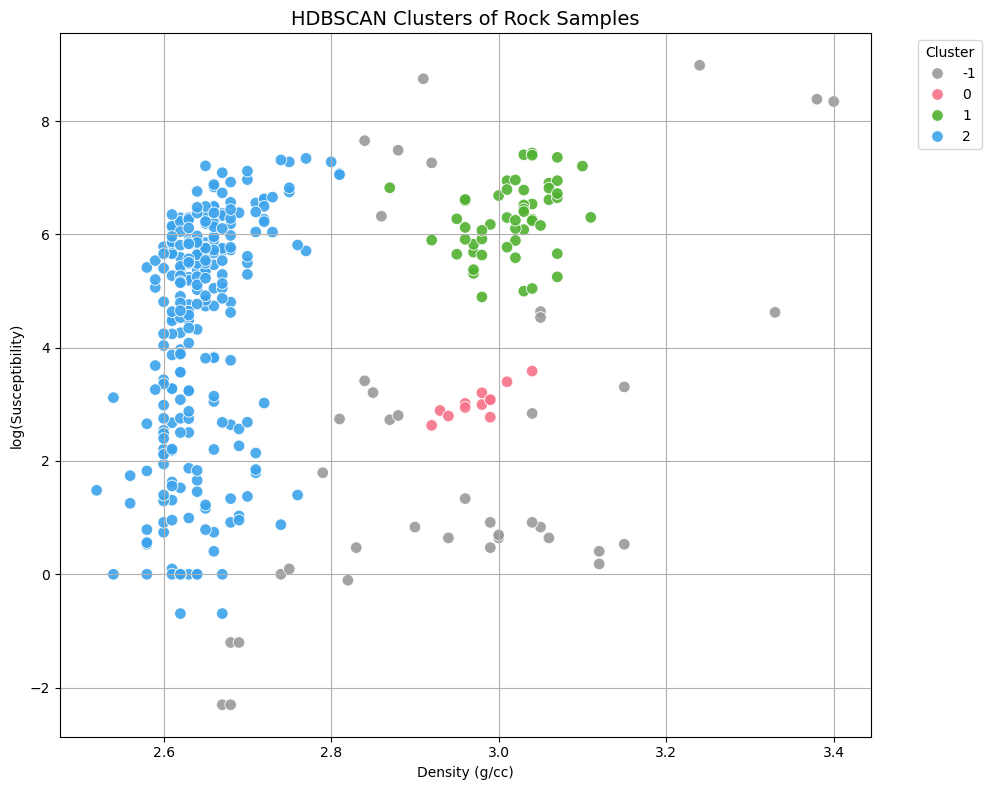

In [28]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_density, x="Density (g/cc)", y="log_Susceptibility", hue="Cluster", 
                palette= cluster_color_dict, s=70, alpha=0.9)

plt.title("HDBSCAN Clusters of Rock Samples", fontsize=14)
plt.xlabel("Density (g/cc)")
plt.ylabel("log(Susceptibility)")
plt.grid(True)
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(rf"{output_dir}\Crossplots\Density vs log(Susceptibility) by Clusters.png")
plt.show()

In [29]:
with rasterio.open(bouguer_anomaly_dir) as src:
    bouguer = src.read(1)
    bouguer_transform = src.transform
    bouguer_meta = src.meta 
    bouguer_crs = src.crs
    bouguer = np.ma.masked_equal(bouguer, bouguer_meta['nodata'])

In [30]:
with rasterio.open(tail_tmi_ge) as src:
    tmi_ge = src.read(1)
    tmi_transform = src.transform
    tmi_meta = src.meta 
    tmi_crs = src.crs
    tmi = np.ma.masked_equal(tmi_ge, tmi_meta['nodata'])

In [31]:
bouguer_transform,

(Affine(500.0, 0.0, 607250.0,
        0.0, -500.0, 1743250.0),)

In [32]:
x = np.linspace(bouguer_transform[2], bouguer_transform[2] + bouguer_transform[0] * bouguer.shape[1], bouguer.shape[1])
y = np.linspace(bouguer_transform[5] + bouguer_transform[4] * bouguer.shape[0], bouguer_transform[5], bouguer.shape[0])
xx, yy = np.meshgrid(x, y)

In [33]:
X = np.linspace(tmi_transform[2], tmi_transform[2] + tmi_transform[0] * tmi.shape[1], tmi.shape[1])    #607181.25, 607181.25*37.5*5055(column), 5055
Y = np.linspace(tmi_transform[5] + tmi_transform[4] * tmi.shape[0], tmi_transform[5], tmi.shape[0])
XX, YY = np.meshgrid(X, Y)

In [34]:
# Flip data 
tmi_corrected = np.flipud(tmi)
bouguer_corrected = np.flipud(bouguer)

tmi_values = tmi_corrected.compressed()
bouguer_values = bouguer_corrected.compressed()

# Get coordinates for valid pixels (if needed)
valid_mask = ~tmi_corrected.mask
XX_valid = XX[valid_mask].ravel()  # Easting (1D)
YY_valid = YY[valid_mask].ravel()  # Northing (1D)

In [35]:
# Create DataFrame
df_tmi = pd.DataFrame({'Easting': XX_valid, 'Northing': YY_valid, 'TMI': tmi_values})

# Get coordinates for valid pixels (if needed)
VALID_MASK = ~bouguer_corrected.mask
xx_valid = xx[VALID_MASK].ravel()  # Easting (1D)
yy_valid = yy[VALID_MASK].ravel()  # Northing (1D)

In [36]:
# Create DataFrame
df_ba = pd.DataFrame({'Easting': xx_valid, 'Northing': yy_valid, 'bouguer_anomaly': bouguer_values})

In [37]:
# Extract BA's original points and values
ba_points = df_ba[['Easting', 'Northing']].values  # Shape: (N, 2)
ba_values = df_ba['bouguer_anomaly'].values        # Shape: (N,)

# Target points (TMI's dense grid)
tmi_target_points = df_tmi[['Easting', 'Northing']].values  # Shape: (M, 2)

# Interpolate BA to TMI's grid
ba_interpolated = griddata(ba_points, ba_values, tmi_target_points, method='cubic', fill_value=np.nan)

# Add interpolated BA to df_tmi
df_tmi['bouguer_anomaly'] = ba_interpolated

In [38]:
df_tmi = df_tmi.dropna(subset=['bouguer_anomaly'])

In [39]:
df_tmi

,Easting,Northing,TMI,bouguer_anomaly
679,621246.532450,1.520381e+06,-67.671829,-105.785695
680,621284.039869,1.520381e+06,-66.926811,-105.785187
681,621321.547289,1.520381e+06,-66.194450,-105.784313
682,621359.054709,1.520381e+06,-65.757286,-105.782896
683,621396.562129,1.520381e+06,-65.766830,-105.781384
...,...,...,...,...
27519321,794530.812228,1.743206e+06,88.309036,-89.841912
27519322,794568.319648,1.743206e+06,88.912506,-89.839613
27519323,794605.827068,1.743206e+06,89.775551,-89.837384
27519324,794643.334488,1.743206e+06,90.551010,-89.835212


#### REMAINING calculation for interpolating bouguer to tmi scale will be continued after the random forest clustering

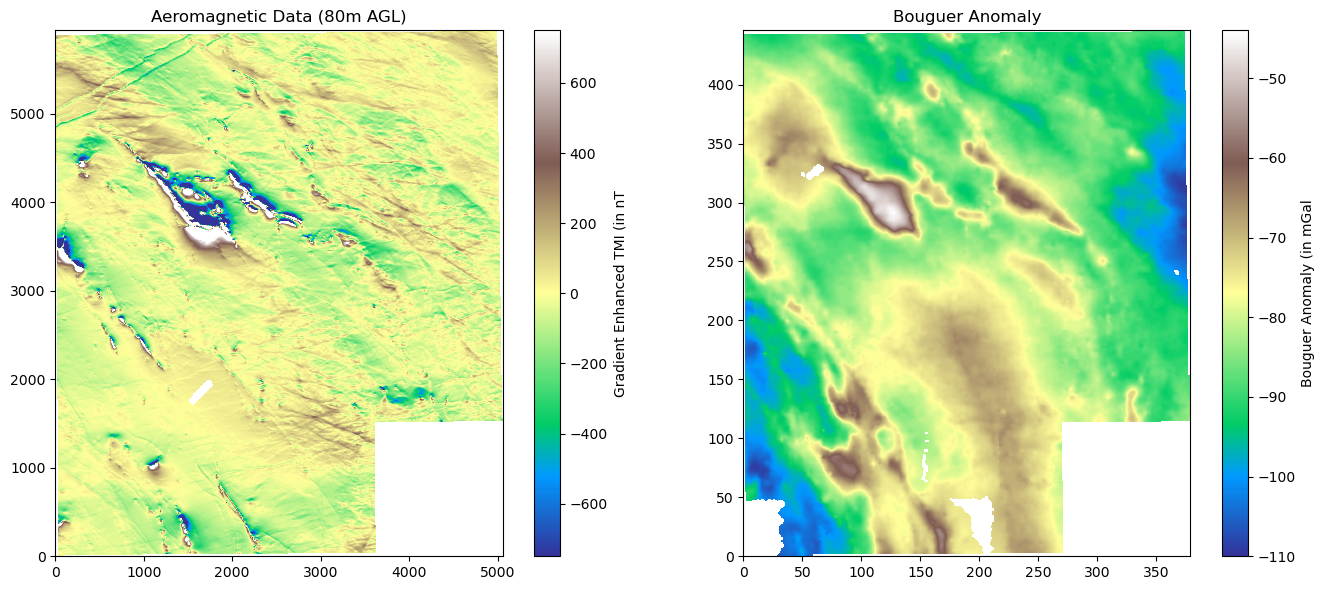

In [42]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14,6))
m = ax[0].imshow(tmi, cmap='terrain', extent=[0, tmi.shape[1], 0, tmi.shape[0]], vmin=-750, vmax=750)
ax[0].set_title('Aeromagnetic Data (80m AGL)')
cbar = fig.colorbar(m, ax=ax[0])
cbar.set_label('Gradient Enhanced TMI (in nT')
g = ax[1].imshow(bouguer, cmap='terrain', extent=[0, bouguer.shape[1], 0, bouguer.shape[0]], vmin=-110, vmax=-44)
ax[1].set_title('Bouguer Anomaly')
cbar = fig.colorbar(g, ax=ax[1])
cbar.set_label('Bouguer Anomaly (in mGal')
plt.tight_layout()
plt.savefig(rf"{output_dir}\Maps\MTI Plot and Bouguer Anomaly Plot.png")
plt.show()

In [51]:
# Normalize x and y coordinates to match raster pixel dimensions
xmin, xmax = 0, tmi.shape[1]
ymin, ymax = 0, tmi.shape[0]

In [52]:
x_norm = (df_density['x'] - df_density['x'].min()) / (df_density['x'].max() - df_density['x'].min()) * (xmax - xmin)
y_norm = (df_density['y'].max() - df_density['y']) / (df_density['y'].max() - df_density['y'].min()) * (ymax - ymin)  # flipped for imshow

In [53]:
df_density['x_im'] = x_norm
df_density['y_im'] = y_norm

In [54]:
tmi_transform

Affine(37.5, 0.0, 607181.25,
       0.0, -37.5, 1743206.25)

In [62]:
points_x = df_density["x"]
points_y = df_density["y"]
cluster_labels = df_density["Cluster"]

In [64]:
cluster_color_dict

{0: (0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 1: (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 2: (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 -1: (0.6, 0.6, 0.6)}

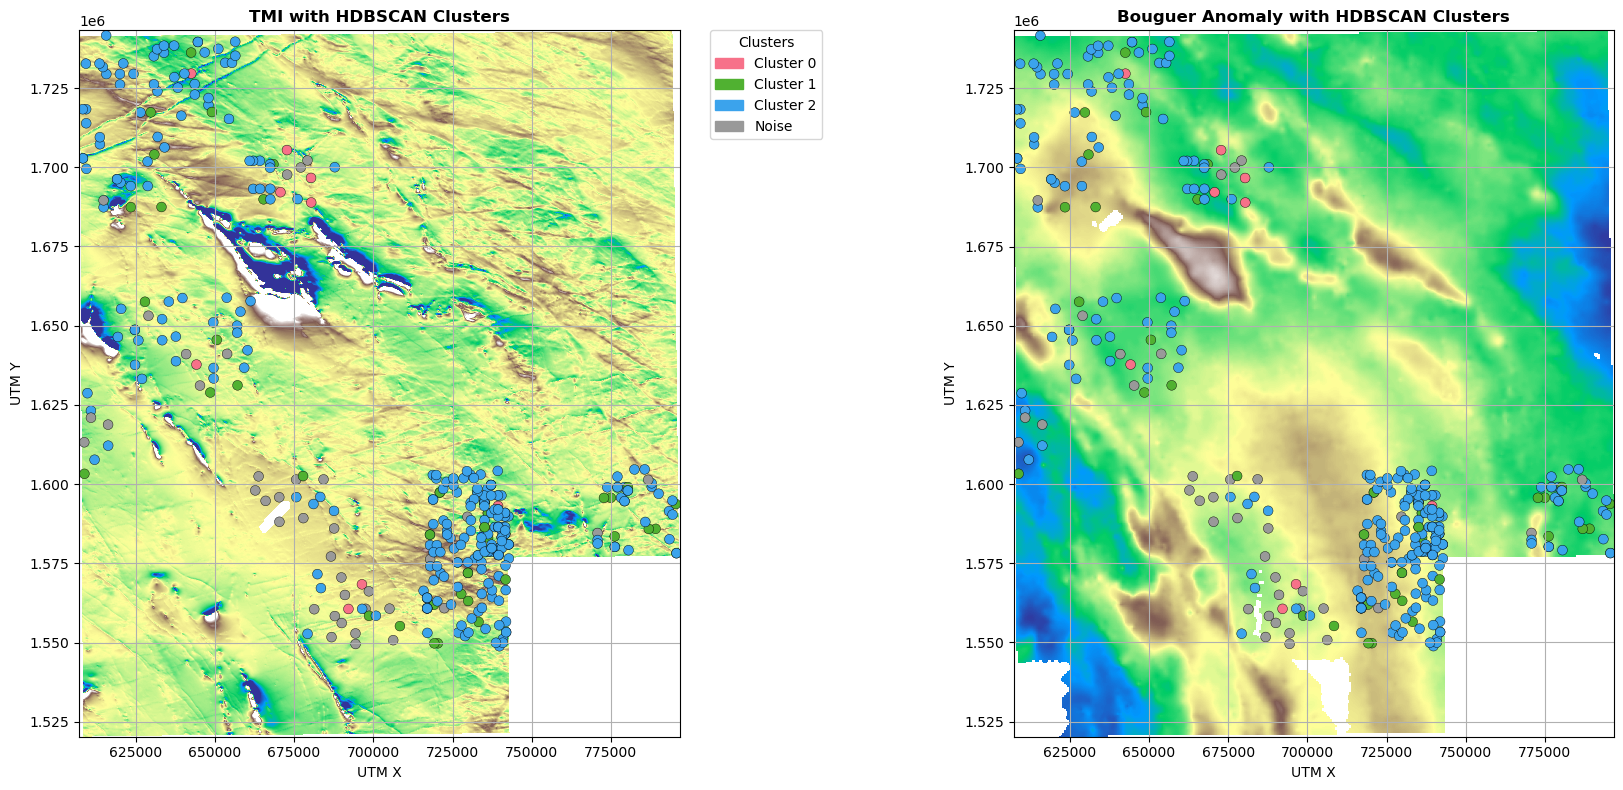

In [65]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
with rasterio.open(tail_tmi_ge) as src_tmi:
    show(src_tmi, ax=axs[0], title="TMI with HDBSCAN Clusters", cmap='terrain', vmin=-500, vmax=500)
    axs[0].scatter(points_x, points_y, c=point_colors, s=50, edgecolor='k', linewidth=0.3)
    axs[0].set_xlabel("UTM X")
    axs[0].set_ylabel("UTM Y")
    axs[0].grid(True)

with rasterio.open(bouguer_anomaly_dir) as src_bouguer:
    show(src_bouguer, ax=axs[1], title="Bouguer Anomaly with HDBSCAN Clusters", cmap='terrain', vmin=-110, vmax=-40)
    axs[1].scatter(points_x, points_y, c=point_colors, s=50, edgecolor='k', linewidth=0.3)
    axs[1].set_xlabel("UTM X")
    axs[1].set_ylabel("UTM Y")
    axs[1].grid(True)

legend_handles = []
for cluster, color in cluster_color_dict.items():
    if cluster == -1:
        label = "Noise"
    else:
        label = f"Cluster {cluster}"
    patch = mpatches.Patch(color=color, label=label)
    legend_handles.append(patch)

axs[0].legend(handles=legend_handles, title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
plt.tight_layout()
plt.savefig(rf"{output_dir}\Maps\Cluster Points overlay on TMI & Bouguer Anomaly Map.png")
plt.show()

In [66]:
def sample_raster_at_points(raster_path, xs, ys):
    with rasterio.open(raster_path) as src:
        nodata_val = src.nodata 
        samples = list(src.sample(list(zip(xs, ys))))
        sampled_vals = [val[0] for val in samples]
        
        # Clean 'nodata' values
        if nodata_val is not None:
            sampled_vals = np.ma.masked_equal(sampled_vals, nodata_val).filled(np.nan)  # Mask and fill with np.nan
        else:
            sampled_vals = np.array(sampled_vals)  
    return sampled_vals

In [67]:
xs = df_density["x"].values
ys = df_density["y"].values

In [68]:
df_density["TMI_value"] = sample_raster_at_points(tail_tmi_ge, xs, ys)
df_density["Bouguer_value"] = sample_raster_at_points(bouguer_anomaly_dir, xs, ys)  

In [70]:
#df_density.dropna(subset=["TMI_value", "Bouguer_value"], inplace=True)

In [72]:
df_density.groupby('Cluster')[['TMI_value', 'Bouguer_value']].describe()

TMI_value                                                            \
            count       mean         std         min         25%        50%   
Cluster                                                                       
-1           40.0 -11.353197   75.667221 -221.073105  -41.519664   7.931821   
 0           12.0 -13.692460   82.293912 -134.509628  -62.745169 -18.647876   
 1           53.0 -23.282769   96.871539 -258.470062  -94.267830 -17.511320   
 2          259.0 -29.545852  116.454787 -404.252380 -104.715855 -32.216671   

                               Bouguer_value                                   \
               75%         max         count       mean       std         min   
Cluster                                                                         
-1       40.108552  104.275864          40.0 -80.423981  7.033586 -100.803925   
 0       29.547537  148.234467          12.0 -80.373743  5.909447  -92.052521   
 1       34.642872  234.361938          53.0 -79.166651  7.847277 -102.671295   
 2       37.228312  370.186340         258.0 -79.541937  7.606756 -105.770020   

                                                     
               25%        50%        75%        max  
Cluster                                              
-1      -84.548233 -78.755096 -76.662931 -66.192352  
 0      -82.630869 -80.287895 -77.282343 -68.448029  
 1      -85.936554 -78.279716 -73.055000 -67.430420  
 2      -85.218891 -79.032684 -73.881723 -65.956184

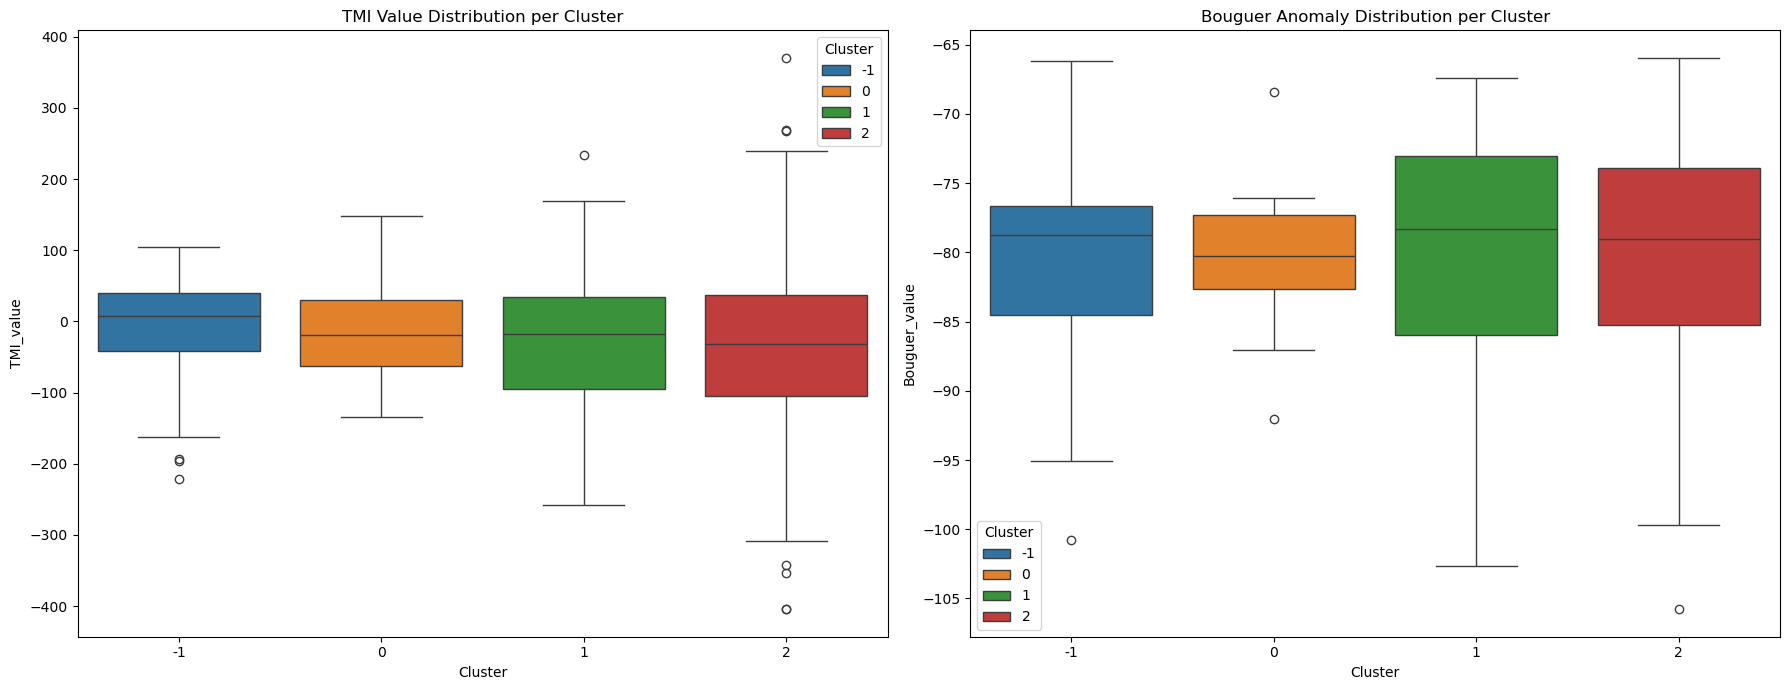

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))

sns.boxplot(data=df_density, x="Cluster", y="TMI_value", ax=axs[0], palette="tab10", hue="Cluster")
axs[0].set_title("TMI Value Distribution per Cluster")

sns.boxplot(data=df_density, x="Cluster", y="Bouguer_value", ax=axs[1], palette="tab10", hue="Cluster", )
axs[1].set_title("Bouguer Anomaly Distribution per Cluster")

plt.tight_layout()
plt.savefig(rf"{output_dir}\Crossplots\Box Plots of Cluster across TMI and BA Anomalies.png")
plt.show()

In [74]:
len(df_density["Bouguer_value"]), len(point_colors)

(364, 364)

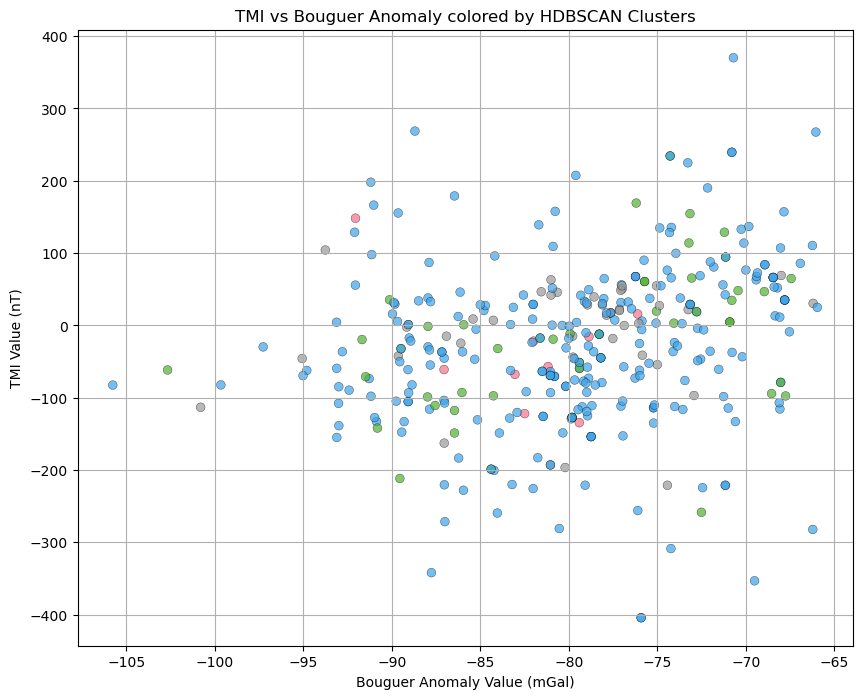

In [75]:
plt.figure(figsize=(10,8))
plt.scatter(df_density["Bouguer_value"], df_density["TMI_value"], c=point_colors, edgecolor='k', linewidth=0.3, alpha=0.7, s=40 )

plt.xlabel("Bouguer Anomaly Value (mGal)")
plt.ylabel("TMI Value (nT)")
plt.title("TMI vs Bouguer Anomaly colored by HDBSCAN Clusters")
plt.savefig(rf"{output_dir}\Crossplots\Clusters across TMI vs Bouguer Anomalies.png")
plt.grid(True)

## Using PCA

In [80]:
df_density

,Latitude,Longitude,Density (g/cc),Rock_type,Susceptibility,x,y,log_Susceptibility,Rocktype_Grouped,Cluster,x_im,y_im,TMI_value,Bouguer_value
0,15.40,76.01,2.62,Pink Granite,35.40,608382.92,1702822.25,3.566712,Pink Granite,2,1.965083,1195.287380,-404.252380,-75.910957
1,15.34,76.11,2.72,Hornblende,739.00,619149.09,1696237.42,6.605298,Other,2,292.455526,1398.373216,-221.108017,-71.155167
2,15.26,76.07,2.56,Pegmatite,5.70,614898.61,1687365.88,1.740466,Other,2,177.770005,1671.984549,-135.079071,-75.208893
3,15.28,76.07,3.05,Gabbro,2.30,614887.73,1689578.35,0.832909,Gabbro,-1,177.476443,1603.748723,-221.073105,-74.426727
4,15.37,76.02,2.52,Pegmatite,4.40,609471.79,1699508.60,1.481605,Other,2,31.344735,1297.485216,5.930889,-75.864708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,14.45,77.57,2.61,Sheared Granite,9.10,777069.64,1599046.37,2.208274,Other,2,4553.433242,4395.888055,1.113027,-89.067070
360,14.33,77.24,2.59,Syeno Granite,26.05,741604.55,1585392.53,3.260018,Other,2,3596.521946,4816.992550,-79.767357,-79.037384
361,14.48,77.09,2.60,Tonalite,122.70,725268.40,1601840.64,4.809742,Other,2,3155.743522,4309.708661,-69.555466,-75.980316
362,14.27,77.05,2.59,Tonalite,181.55,721161.92,1578562.85,5.201531,Other,2,3044.943377,5027.629920,85.857719,-66.915421


In [109]:
df_density = df_density.copy()
df_density["Bouguer_value"] = df_density["Bouguer_value"].fillna(df_density["Bouguer_value"].mean())

In [86]:
df_density["TMI/Bouguer"] = (df_density["TMI_value"].values)/(df_density["Bouguer_value"].values)
df_density["TMI_Bouguer_Scaled"] = ((df_density["TMI_value"].values)-(df_density["TMI_value"].values.mean())*
                                        (df_density["Bouguer_value"].values)-(df_density["Bouguer_value"].values.mean()))

In [111]:
X = df_density[["TMI_value", "Bouguer_value","log_Susceptibility", "Density (g/cc)"]]      # Can use "Susceptibility", "Density (g/cc)"
y = df_density["Cluster"]

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [115]:
model = RandomForestClassifier(n_estimators=1000, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=1000,
                       random_state=42)

Classification Report:
              precision    recall  f1-score   support

          -1       1.00      0.60      0.75        10
           0       0.60      1.00      0.75         3
           1       1.00      1.00      1.00        13
           2       0.97      1.00      0.98        65

    accuracy                           0.96        91
   macro avg       0.89      0.90      0.87        91
weighted avg       0.97      0.96      0.95        91

Accuracy: 0.956
Confusion Matrix:


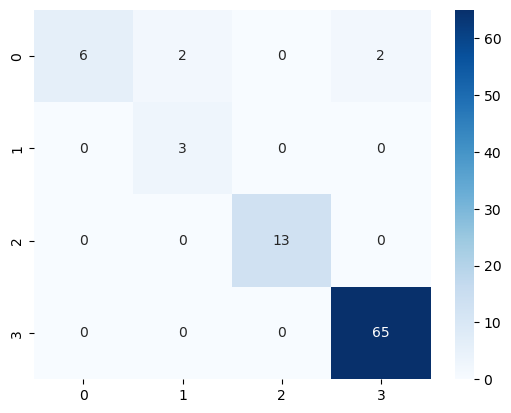

In [119]:
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.show()


Classification Report:
              precision    recall  f1-score   support

          -1     1.0000    0.6000    0.7500        10
           0     0.6000    1.0000    0.7500         3
           1     1.0000    1.0000    1.0000        13
           2     0.9701    1.0000    0.9848        65

    accuracy                         0.9560        91
   macro avg     0.8925    0.9000    0.8712        91
weighted avg     0.9655    0.9560    0.9535        91



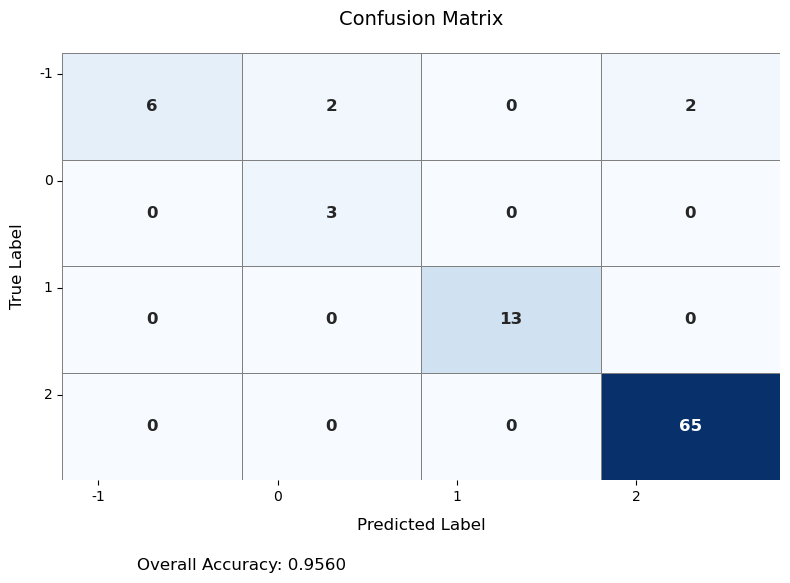

In [131]:
# Model Evaluation
y_pred = model.predict(X_test)

# Classification Report
print("\n\033[1mClassification Report:\033[0m")
print("=" * 60)
clf_report = classification_report(y_test, y_pred, digits=4)
print(clf_report)

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            cbar=False,
            linewidths=0.5,
            linecolor='gray',
            annot_kws={'size': 12, 'weight': 'bold'})

# Add labels and title
classes = np.unique(y_test)
tick_marks = np.arange(len(classes)) + 0.2
plt.xticks(tick_marks, classes, rotation=0)
plt.yticks(tick_marks, classes, rotation=0)
plt.xlabel('Predicted Label', fontsize=12, labelpad=10)
plt.ylabel('True Label', fontsize=12, labelpad=10)
plt.title('Confusion Matrix', fontsize=14, pad=20)

# Add accuracy score to the plot
accuracy = np.trace(conf_mat) / np.sum(conf_mat)
plt.text(0.25, -0.2, f'Overall Accuracy: {accuracy:.4f}', 
         ha='center', va='center', 
         transform=plt.gca().transAxes,
         fontsize=12)

plt.tight_layout()
plt.show()

In [84]:
grid_features = df_density[["TMI_value", "Bouguer_value", "log_Susceptibility", "Density (g/cc)"]]    
grid_preds = model.predict(grid_features)
df_density["Predicted_Cluster"] = grid_preds

probs = model.predict_proba(grid_features)
df_density[["Prob_Cluster_0", "Prob_Cluster_1", "Prob_Cluster_2", "Prob_Noise"]] = probs

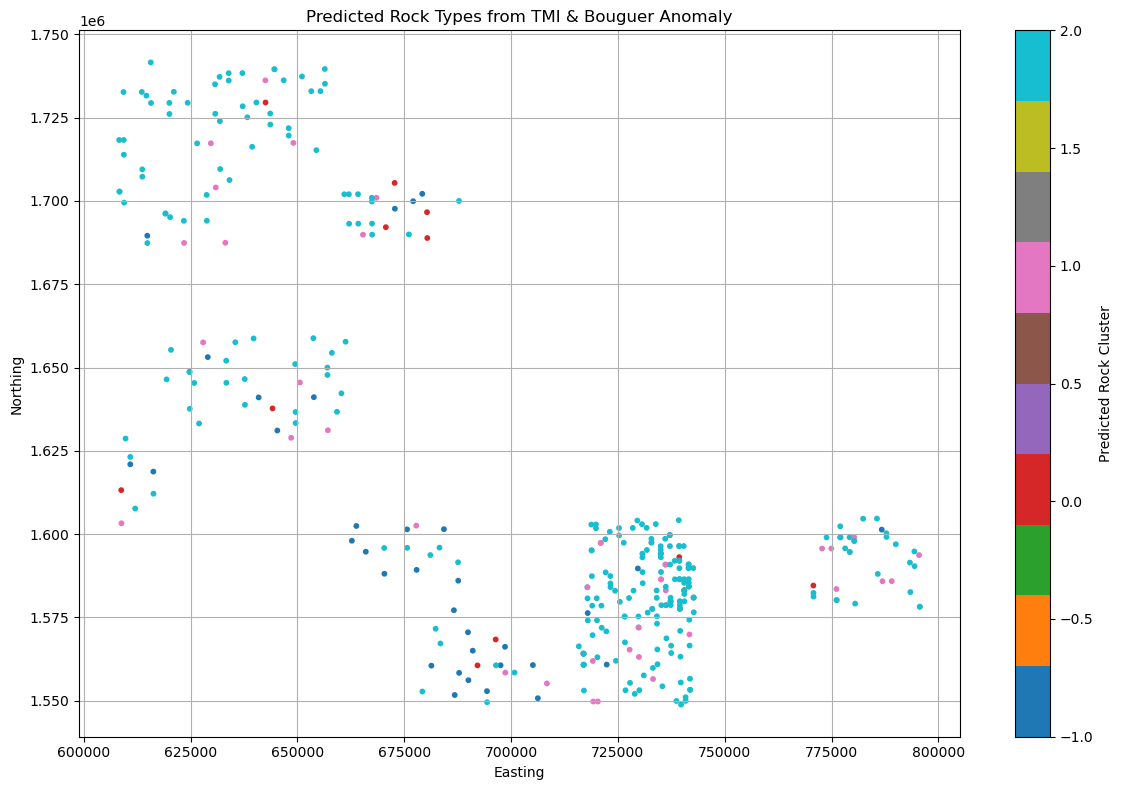

In [85]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_density["x"], df_density["y"], c=df_density["Predicted_Cluster"], cmap="tab10", s=10)
plt.colorbar(scatter, label="Predicted Rock Cluster")
plt.title("Predicted Rock Types from TMI & Bouguer Anomaly")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Continuation calculation for interpolating bouguer & susceptibility:

In [333]:
X_known = df_density[['x', 'y']].values
y_known = df_density['Density (g/cc)'].values
X_target = df_tmi[['Easting', 'Northing']].values
Y_known = df_density['log_Susceptibility'].values

In [317]:
X_target = df_tmi[['Easting', 'Northing']].values

In [371]:
knn = KNeighborsRegressor(n_neighbors=10, weights='distance')
knn.fit(X_known, y_known)

KNeighborsRegressor(n_neighbors=10, weights='distance')

In [373]:
interpolated_density = knn.predict(X_target)

In [374]:
knn.fit(X_known, Y_known)

KNeighborsRegressor(n_neighbors=10, weights='distance')

In [375]:
interpolated_susceptibility = knn.predict(X_target)

In [376]:
nan_den = np.isnan(interpolated_density).sum()
nan_sus = np.isnan(interpolated_susceptibility).sum()
print(nan_sus, nan_den)

0 0


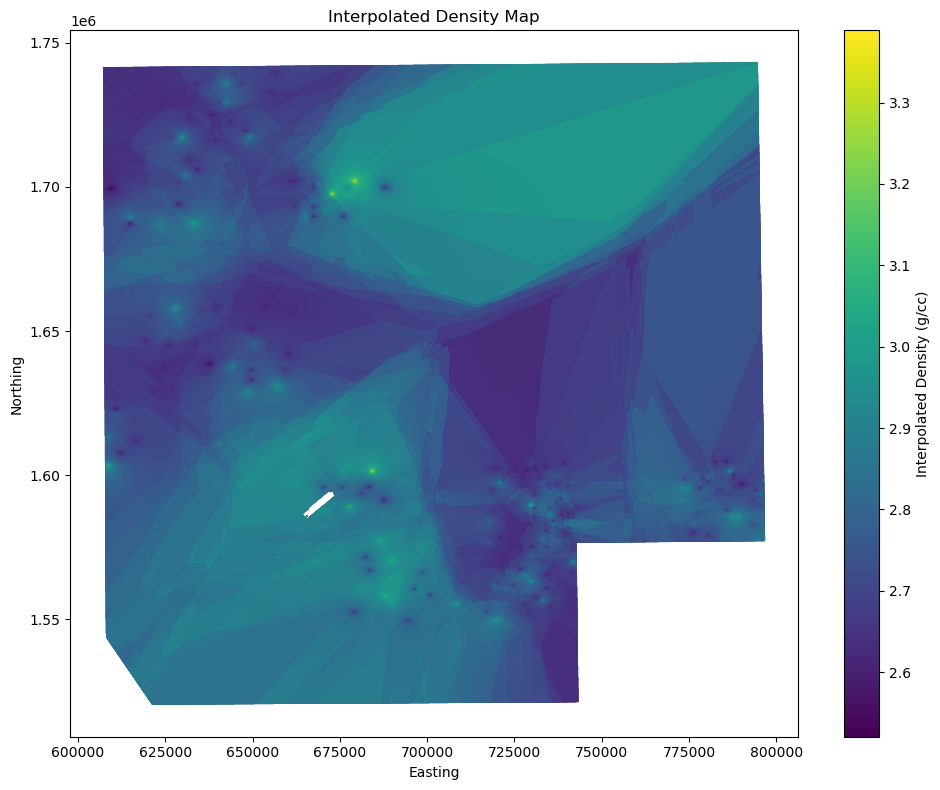

In [377]:
east = df_tmi['Easting'].astype(np.float32).values
north = df_tmi['Northing'].astype(np.float32).values
int_den = interpolated_density.astype(np.float32)

# Plot using tiny markers to reduce render time and memory use
plt.figure(figsize=(10, 8))
plt.scatter(east, north, c=int_den, s=0.25, cmap='viridis', marker='.', edgecolors='none')
plt.colorbar(label='Interpolated Density (g/cc)')
plt.title('Interpolated Density Map')
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.tight_layout()
plt.show()

In [383]:
X_pred = np.vstack((df_tmi['TMI'], df_tmi['bouguer_anomaly'],interpolated_susceptibility, interpolated_density)).T

In [ ]:
cluster_preds = model.predict(X_pred)

C:\Users\Kunal\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
cluster_preds

In [ ]:
plt.hist(cluster_preds,bins=10)
#plt.ylim(0,25)
plt.show()

In [ ]:
df_tmi['cluster_preds'] = cluster_preds

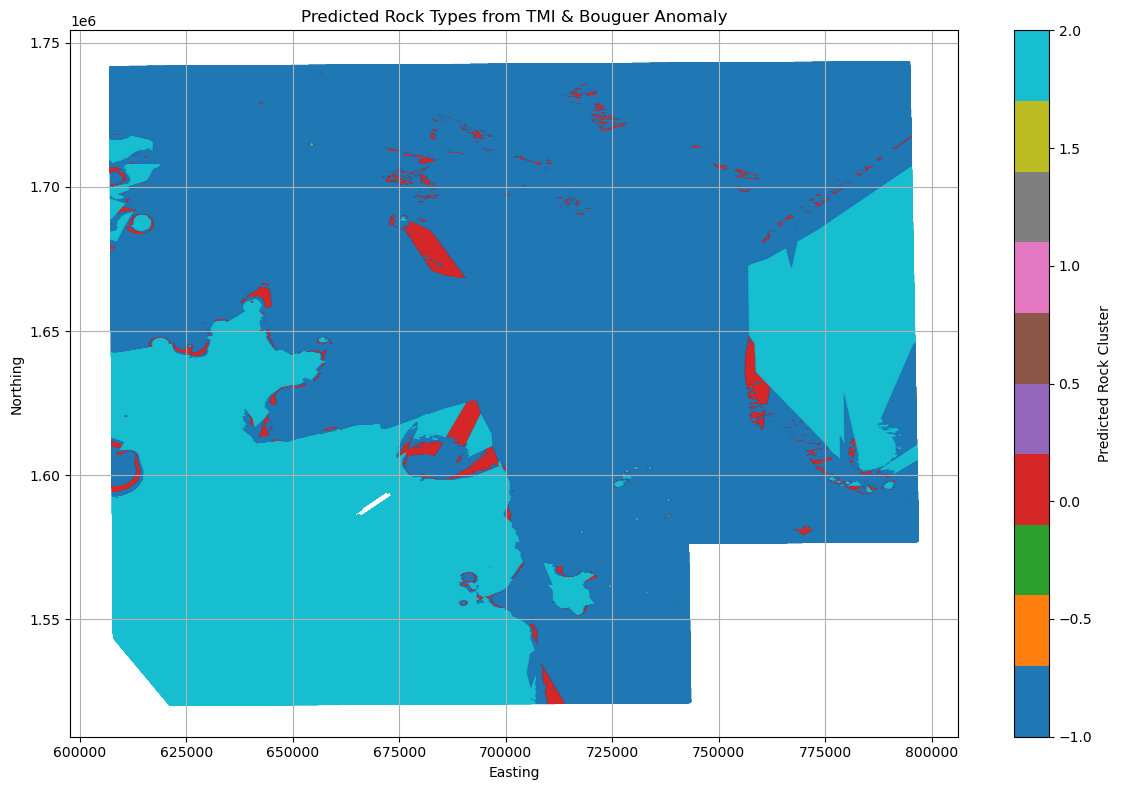

In [355]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_tmi["Easting"], df_tmi["Northing"], c=df_tmi["cluster_preds"], cmap="tab10", s=0.5)
plt.colorbar(scatter, label="Predicted Rock Cluster")
plt.title("Predicted Rock Types from TMI & Bouguer Anomaly")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.grid(True)
plt.tight_layout()
plt.show()

In [182]:
df_density.to_csv(output_dir+r"\Point-Shape Files\Clusters.csv", 
          columns=['x', 'y', 'Cluster'],  
          index=False)

In [183]:
df_density['Rock_type']

,Latitude,Longitude,Density (g/cc),Rock_type,Susceptibility,x,y,log_Susceptibility,Rocktype_Grouped,Cluster,x_im,y_im,TMI_value,Bouguer_value
0,15.40,76.01,2.62,Pink Granite,35.40,608382.92,1702822.25,3.566712,Pink Granite,2,1.965083,1195.287380,-404.252380,-75.910957
1,15.34,76.11,2.72,Hornblende,739.00,619149.09,1696237.42,6.605298,Other,2,292.455526,1398.373216,-221.108017,-71.155167
2,15.26,76.07,2.56,Pegmatite,5.70,614898.61,1687365.88,1.740466,Other,2,177.770005,1671.984549,-135.079071,-75.208893
3,15.28,76.07,3.05,Gabbro,2.30,614887.73,1689578.35,0.832909,Gabbro,-1,177.476443,1603.748723,-221.073105,-74.426727
4,15.37,76.02,2.52,Pegmatite,4.40,609471.79,1699508.60,1.481605,Other,2,31.344735,1297.485216,5.930889,-75.864708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,14.45,77.57,2.61,Sheared Granite,9.10,777069.64,1599046.37,2.208274,Other,2,4553.433242,4395.888055,1.113027,-89.067070
360,14.33,77.24,2.59,Syeno Granite,26.05,741604.55,1585392.53,3.260018,Other,2,3596.521946,4816.992550,-79.767357,-79.037384
361,14.48,77.09,2.60,Tonalite,122.70,725268.40,1601840.64,4.809742,Other,2,3155.743522,4309.708661,-69.555466,-75.980316
362,14.27,77.05,2.59,Tonalite,181.55,721161.92,1578562.85,5.201531,Other,2,3044.943377,5027.629920,85.857719,-66.915421


In [184]:
clusters = sorted(c for c in df_density["Cluster"].unique() if c != -1)

In [185]:
for cluster in clusters:
    cluster_data = df_density[df_density["Cluster"] == cluster][["Bouguer_value", "TMI_value"]]
    
    mean_vec = cluster_data.mean().values
    cov_matrix = cluster_data.cov().values
    
    print(f"\n Cluster {cluster}")
    print(f"Mean vector (Bouger, TMI): {mean_vec}")
    print("Covariance Matrix:")
    print(cov_matrix)


 Cluster 0
Mean vector (Bouger, TMI): [-80.37374306 -13.69245958]
Covariance Matrix:
[[  34.92156956   20.7963062 ]
 [  20.7963062  6772.28797906]]

 Cluster 1
Mean vector (Bouger, TMI): [-79.16665074 -23.28276852]
Covariance Matrix:
[[  61.57974967  316.41297474]
 [ 316.41297474 9384.09503993]]

 Cluster 2
Mean vector (Bouger, TMI): [-79.54193659 -29.54585238]
Covariance Matrix:
[[   57.86273223   176.3465991 ]
 [  176.3465991  13561.71731065]]


In [186]:
cluster_color_dict 

{0: (0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 1: (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 2: (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 -1: (0.6, 0.6, 0.6)}

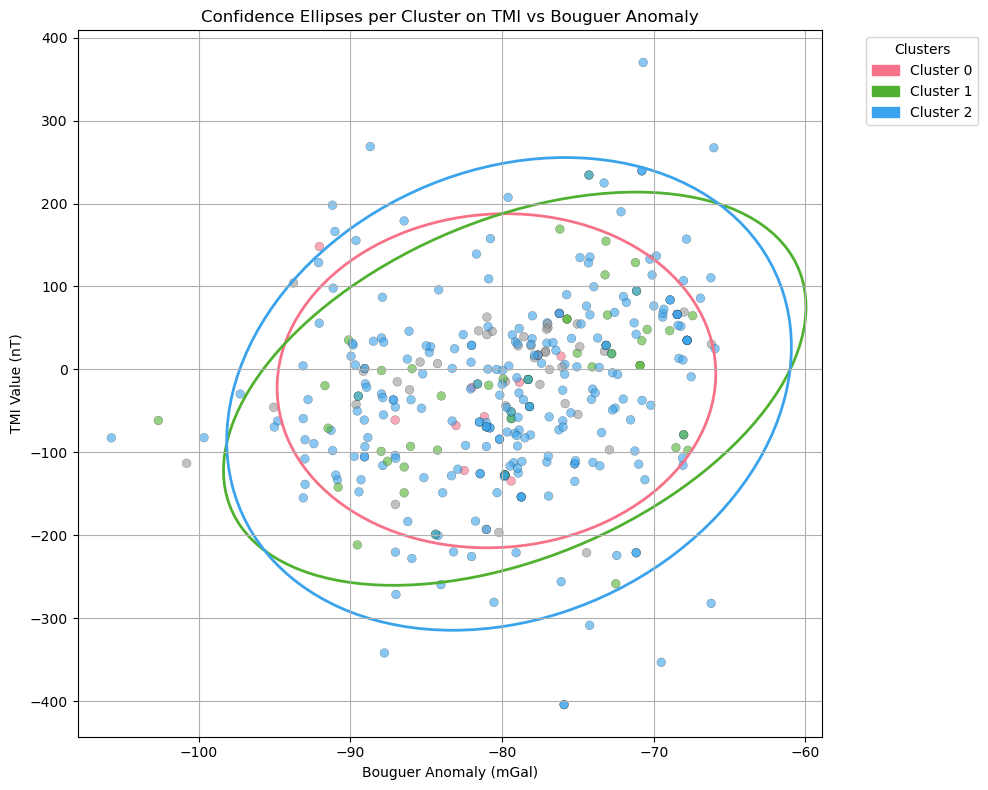

In [187]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(df_density["Bouguer_value"], df_density["TMI_value"], c=point_colors, alpha=0.6, edgecolor='k', linewidth=0.2, s=40)

def plot_cov_ellipse(mean, cov, ax, n_std=2.4477, edgecolor='black', facecolor='none', **kwargs):
    # n_std=2.4477 for ~95% confidence (Chi-square distribution for 2 variables)
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(eigvals)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                      edgecolor=edgecolor, facecolor=facecolor, lw=2, **kwargs)
    ax.add_patch(ellipse)

#ELLIPSE
for cluster in clusters:
    cluster_data = df_density[df_density["Cluster"] == cluster][["Bouguer_value", "TMI_value"]]
    mean_vec = cluster_data.mean().values
    cov_matrix = cluster_data.cov().values
    plot_cov_ellipse(mean_vec, cov_matrix, ax,
                     edgecolor=cluster_color_dict[cluster], facecolor='none')

ax.set_xlabel("Bouguer Anomaly (mGal)")
ax.set_ylabel("TMI Value (nT)")
ax.set_title("Confidence Ellipses per Cluster on TMI vs Bouguer Anomaly")
ax.grid(True)

legend_handles = [mpatches.Patch(color=cluster_color_dict[c], label=f"Cluster {c}") for c in clusters]
ax.legend(handles=legend_handles, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig(rf"{output_dir}\Crossplots\Confidence Ellipses per Cluster on TMI vs Bouguer Anomaly.png")
plt.show()

In [188]:
Dose_dir = r"C:\Data\ONGC\AIKosh\aerogeophysical_spectrometric_data\SPECTROMETRIC\GRIDS\GEOTIFF\Dose_rate_TC.tiff"
eTh_dir = r"C:\Data\ONGC\AIKosh\aerogeophysical_spectrometric_data\SPECTROMETRIC\GRIDS\GEOTIFF\eTh_ppm.tiff"
eU_dir = r"C:\Data\ONGC\AIKosh\aerogeophysical_spectrometric_data\SPECTROMETRIC\GRIDS\GEOTIFF\eU_ppm.tiff"
K_dir = "C:\Data\ONGC\AIKosh\aerogeophysical_spectrometric_data\SPECTROMETRIC\GRIDS\GEOTIFF\K_perc.tiff"

In [189]:
raster_paths = [
    r"C:\Data\ONGC\AIKosh\Aerogeophysical_spectrometric_data\SPECTROMETRIC\GRIDS\GEOTIFF\K_perc.tiff",
    r"C:\Data\ONGC\AIKosh\Aerogeophysical_spectrometric_data\SPECTROMETRIC\GRIDS\GEOTIFF\eTh_ppm.tiff",
    r"C:\Data\ONGC\AIKosh\Aerogeophysical_spectrometric_data\SPECTROMETRIC\GRIDS\GEOTIFF\eU_ppm.tiff",
    r"C:\Data\ONGC\AIKosh\Aerogeophysical_spectrometric_data\SPECTROMETRIC\GRIDS\GEOTIFF\Dose_rate_TC.tiff",
]

In [190]:
arrays = []
profile = None  
for idx, path in enumerate(raster_paths):
    with rasterio.open(path) as src:
        arrays.append(src.read(1))
        if idx == 0:
            profile = src.profile.copy() 

In [191]:
X = np.stack(arrays, axis=-1)
nrows, ncols, n_features = X.shape
X_flat = X.reshape(-1, n_features)


In [192]:
# 3. Train Isolation Forest
model = IsolationForest(contamination=0.05, random_state=42)
model.fit(X_flat)
predictions = model.predict(X_flat)  # -1 = anomaly, 1 = normal

In [193]:
anomaly_grid = predictions.reshape(nrows, ncols)

In [194]:
# 5. Save anomaly raster
anomaly_grid = (anomaly_grid == -1).astype(np.uint8)  # Convert to 0/1

In [188]:
profile.update(dtype=rasterio.uint8, count=1, nodata=255)

In [191]:
anomaly_output_dir = r"C:\Data\ONGC\AIKosh\OUTPUT\Spectrometric_Data"
os.makedirs(anomaly_output_dir, exist_ok=True)  # Creates if it doesn't exist

anomaly_output_path = os.path.join(anomaly_output_dir, "Anomaly_map.tif")


In [192]:
with rasterio.open(anomaly_output_path, "w", **profile) as dst:
    dst.write(anomaly_grid, 1)